###Importing and Loading the data 



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression, Ridge
from statistics import mean
from sklearn.preprocessing import StandardScaler
from yellowbrick.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
import joblib

In [ ]:
df = pd.read_csv("Lanl.csv")

In [ ]:
df = df.drop("Unnamed: 0" , axis = 1)

In [ ]:
df.shape

(3958, 11)

In [ ]:
df.head(1)

,2_Std300,3_skew80,2_min80,3_skew300,1_skew10,2_Std80,3_Mean10,2_skew10,2_min300,2_90th precentile10,time_to_failure
0,1.95718,0.84258,2.042236,1.854091,2.580269,1.939159,0.070303,2.577872,2.390699,5.80804,1.4649


In [ ]:
x = df.iloc[: , :-1]
y = df.iloc[: , -1]

#PCA

In [ ]:
pca = PCA(n_components = len(x.columns))
pca.fit(x)

PCA(n_components=10)

Elbow method for number of components to chose for Pca.

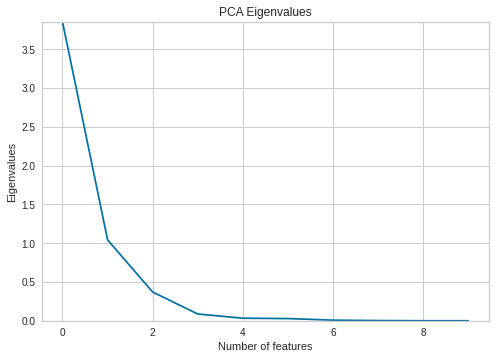

In [ ]:
plt.ylabel("Eigenvalues")
plt.xlabel("Number of features")
plt.title("PCA Eigenvalues")
plt.ylim(0 , max(pca.explained_variance_))
plt.plot(pca.explained_variance_)
plt.show()

Kaiser rule

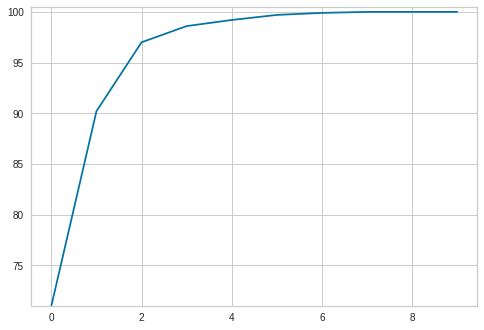

In [ ]:
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 3)*100)

plt.ylim(min(var), 100.5)
plt.style.context("seaborn-whitegrid")
plt.plot(var)
plt.show()

Since to 2 components have variance more than 80%, we will chose n_compunents as 2.

In [ ]:
pca = PCA(n_components = 2)
x = pca.fit_transform(x)

#Splitting the data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.10)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, test_size = 0.10)

#Standardizing the data

In [ ]:
scaler = StandardScaler()
x_tr = scaler.fit(x_tr)

In [ ]:
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)
x_cv = scaler.transform(x_cv)
x_test = scaler.transform(x_test)

In [ ]:
joblib.dump(x_tr, 'scalar.pkl')

['scalar.pkl']

#Linear regresion with L2 regularizer

In [ ]:
cross_val_scores_ridge = []

alpha = []

for i in range(1, 9):
    rgm = Ridge(alpha = i * 0.25)
    rgm.fit(x_tr, y_tr)
    scores = cross_val_score(rgm, x_train, y_train, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_ridge.append(avg_cross_val_score)
    alpha.append(i * 0.25)
 
for i in range(0, len(alpha)):
    print("For alpha " , str(alpha[i])+" the score is : "+str(cross_val_scores_ridge[i]))

For alpha  0.25 the score is : 36.03645255796754
For alpha  0.5 the score is : 35.86495864386414
For alpha  0.75 the score is : 35.68271478827094
For alpha  1.0 the score is : 35.51007271383636
For alpha  1.25 the score is : 35.35273766785439
For alpha  1.5 the score is : 35.21133864407974
For alpha  1.75 the score is : 35.08476448530414
For alpha  2.0 the score is : 34.971403494211664


Text(0, 0.5, 'Alpha')

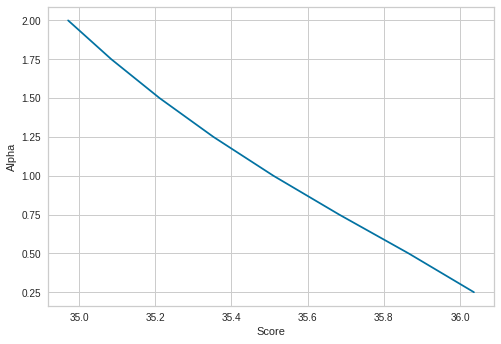

In [ ]:
plt.plot(cross_val_scores_ridge , alpha)
plt.xlabel("Score")
plt.ylabel("Alpha")


After applying L2 regularizer and parameter tunning, from the above graph, we can see that alpha at 0.25 is the best alpha.

In [ ]:
lr = Ridge(alpha = 0.25)
lr.fit(x_tr , y_tr)

Ridge(alpha=0.25)

In [ ]:
pred_train = lr.predict(x_tr)
pred_cv = lr.predict(x_cv)
pred_test = lr.predict(x_test)

In [ ]:
print(mean_absolute_error(y_tr, pred_train))
print(mean_absolute_error(y_cv, pred_cv))
mean_absolute_error(y_test, pred_test)

2.785254635373622
2.702030693833735


2.7276969795643096

Using the linear regression the model is predicting well however using polynomial regression the model was not performing well.


#KNN

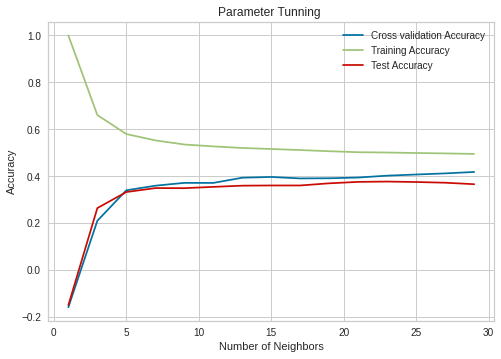

In [ ]:
n_neighbors = list(range(1,30 , 2))

train_accuracy = np.empty(len(n_neighbors))
cv_accuracy = np.empty(len(n_neighbors))
test_accuracy = np.empty(len(n_neighbors))

for i, k in enumerate(n_neighbors):

    knn = KNeighborsRegressor(n_neighbors = k)
    
    knn.fit(x_tr, y_tr)

    train_accuracy[i] = knn.score(x_tr, y_tr)

    cv_accuracy[i] = knn.score(x_cv, y_cv)

    test_accuracy[i] = knn.score(x_test , y_test)


plt.title('Parameter Tunning ')
plt.plot(n_neighbors, cv_accuracy, label = 'Cross validation Accuracy')
plt.plot(n_neighbors, train_accuracy, label = 'Training Accuracy')
plt.plot(n_neighbors, test_accuracy, label = 'Test Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Fig 1


The difference between training accuracy, test accuracy and cross validation accuracy is minimum from k = 10. To get better view, we will use Gridsearch.

Gridsearch Cross validation KNN

In [ ]:
#https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    
    _, ax = plt.subplots(1,1 , figsize=(15,15))

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores")
    ax.set_xlabel(name_param_1)
    ax.set_ylabel('Score')
    ax.legend(loc="best")
    ax.grid('on')

In [ ]:
n_neighbors = list(range(1,30 , 2))

hyperparameters = dict(n_neighbors = n_neighbors)

m_knn = KNeighborsRegressor()

reg = GridSearchCV(m_knn, hyperparameters, cv=10 , scoring='neg_mean_absolute_error')

model = reg.fit(x_tr,y_tr)

model.best_params_

{'n_neighbors': 25}

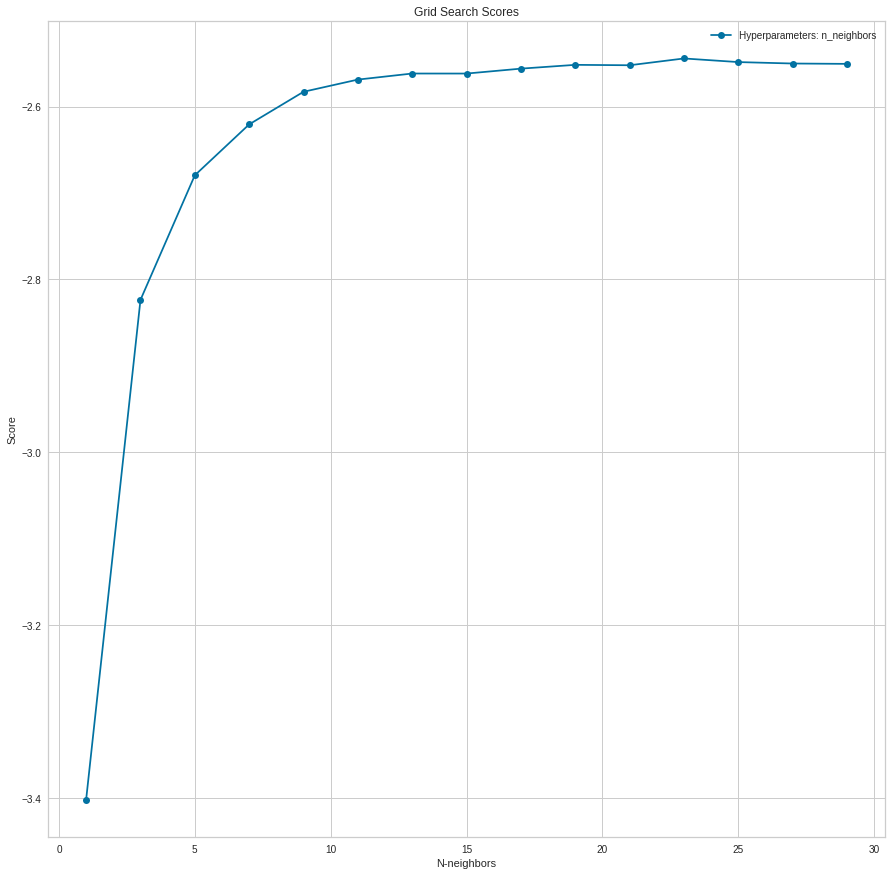

In [ ]:
plot_grid_search(model.cv_results_, n_neighbors,hyperparameters, 'N-neighbors', 'Hyperparameters')

From the above plot and grid search, k = 25 has the best accuracy. So we will chose k = 25

In [ ]:
Knn_model = KNeighborsRegressor(n_neighbors = 25)
Knn_model.fit(x_tr, y_tr)

KNeighborsRegressor(n_neighbors=25)

In [ ]:
pred_train = Knn_model.predict(x_tr)
pred_cv = Knn_model.predict(x_cv)
pred_test = Knn_model.predict(x_test)

In [ ]:
print(mean_absolute_error(y_tr, pred_train))
print(mean_absolute_error(y_cv, pred_cv))
mean_absolute_error(y_test, pred_test)

2.414935278032408
2.5086989311775967


2.4849612851619605

From the fig 1  and grid search cross validation, we choose K = 25. It is neither overfitting nor underfitting. 

Random forest

In [ ]:
#n_estimators = [i for i in range(5 , 500, 10)] Taking too much time

In [ ]:
n_estimators = [5,10,15, 20, 25, 30, 40 , 50, 60 , 100  , 200 , 400]

In [ ]:
n_estimators = [5,10,15, 20, 25, 30, 40 , 50]
max_depth = [i for i in range(5 , 25 , 2)]
bootstrap = [True, False]
min_samples_split = [2, 5, 10]
max_features = ['auto', 'sqrt']

In [ ]:
reg  = RandomForestRegressor()
params = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split
          ,'bootstrap': bootstrap}

random_forest_clf = RandomizedSearchCV(reg, params, scoring='neg_mean_absolute_error', cv = 10, n_iter = 100, verbose = 2, return_train_score=True) 

random_forest_clf.fit(x_tr, y_tr)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_split=5, n_estimators=25; total time=   0.5s
[CV] END bootst

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 7, 9, 11, 13, 15, 17,
                                                      19, 21, 23],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [5, 10, 15, 20, 25, 30,
                                                         40, 50]},
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=2)

In [ ]:
random_forest_clf.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 9,
 'bootstrap': True}

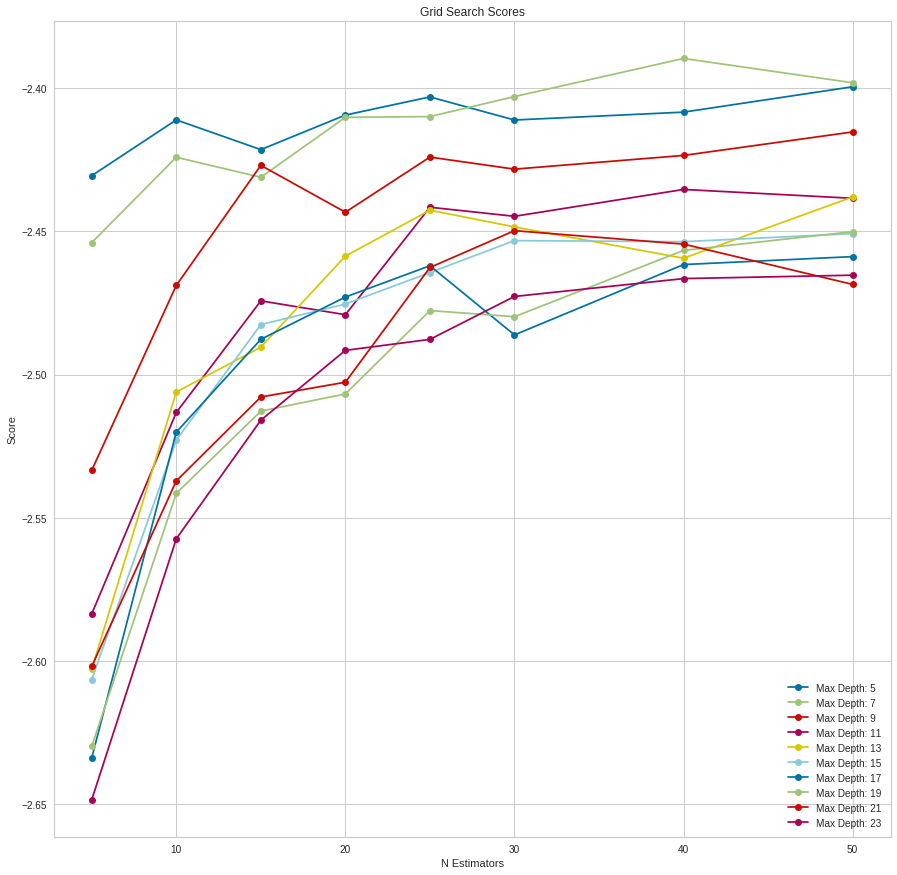

In [ ]:
plot_grid_search(random_forest_clf.cv_results_, n_estimators, max_depth, 'N Estimators', 'Max Depth')

After using gridsearch we got the best parameters and they are max depth = 7 and n_estimator = 50. Instaed of grid search we can also use randomized search.

In [ ]:
random_forest_clf1 = RandomForestRegressor(max_depth = 9 ,n_estimators = 50 , min_samples_split = 10, bootstrap = True, max_features = "sqrt" )
random_forest_clf1.fit(x_tr , y_tr) 

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_split=10,
                      n_estimators=50)

In [ ]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
from sklearn.model_selection import learning_curve
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes = None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    if axes is None:
        _, axes = plt.subplots(1,1, figsize=(10, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

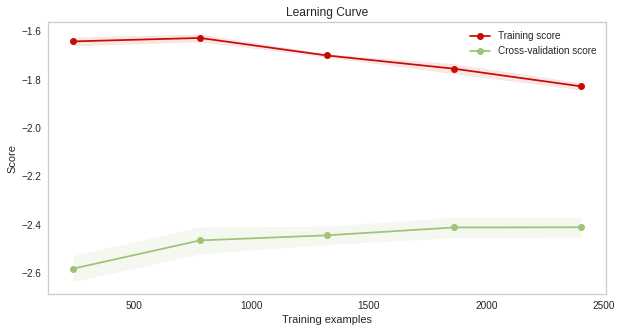

In [ ]:
from sklearn.model_selection import learning_curve
plot_learning_curve(random_forest_clf1,"Learning Curve", x_tr, y_tr.values, cv = 4, scoring='neg_mean_absolute_error')

In [ ]:
pred_train = random_forest_clf1.predict(x_tr)
pred_cv = random_forest_clf1.predict(x_cv)
pred_test = random_forest_clf1.predict(x_test)

In [ ]:
print(mean_absolute_error(y_tr, pred_train))
print(mean_absolute_error(y_cv, pred_cv))
mean_absolute_error(y_test, pred_test)

1.9831843011567618
2.3997761211591198


2.4119566043405225

Using the best parameters our model is neither uderfiiting nor overfitting.


###XGBRegressor

In [ ]:
import xgboost as xgb 

In [ ]:
clf2 = xgb.XGBRegressor(objective="reg:squarederror")
params = { "n_estimators": n_estimators, "max_depth":max_depth } 
xgb_reg = GridSearchCV(clf2, params, scoring = "neg_mean_absolute_error")
xgb_reg.fit(x_tr, y_tr)
xgb_reg.best_params_

{'max_depth': 5, 'n_estimators': 50}

Similar to random forest, after using gridsearch we got the best parameters and they are max depth = 5 and n_estimator = 50.

In [ ]:
xgb_reg = xgb.XGBRegressor(max_depth = 5 ,n_estimators = 50, objective="reg:squarederror" )
xgb_reg.fit(x_tr , y_tr) 

XGBRegressor(max_depth=5, n_estimators=50, objective='reg:squarederror')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

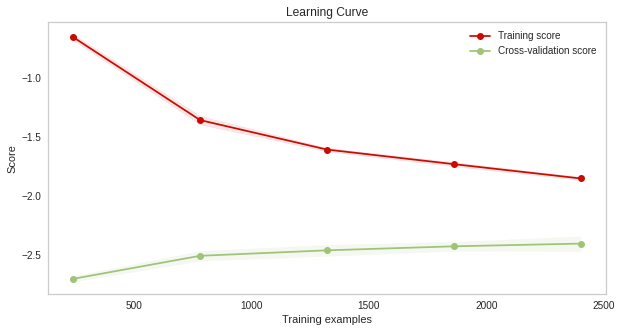

In [ ]:
plot_learning_curve(xgb_reg,"Learning Curve", x_tr, y_tr.values, cv = 4, scoring='neg_mean_absolute_error')

In [ ]:
pred_train = xgb_reg.predict(x_tr)
pred_cv = xgb_reg.predict(x_cv)
pred_test = xgb_reg.predict(x_test)

In [ ]:
print(mean_absolute_error(y_tr, pred_train))
print(mean_absolute_error(y_cv, pred_cv))
mean_absolute_error(y_test, pred_test)

1.950218899934272
2.3685583732846127


2.425800022199712

After using the best parameters our model is neither overfitting nor underfiiting and from the graph we can see that max_depth = 5, and n_estimators = 50 are the best parameters.


Now lets save our models so that we can use them whenever we want.

In [ ]:
joblib.dump(xgb_reg, 'RBG.pkl')

['RBG.pkl']

In [ ]:
joblib.dump(random_forest_clf, 'Forest.pkl')

['Forest.pkl']

In [ ]:
joblib.dump(Knn_model, 'Knn.pkl')

['Knn.pkl']

#Taking average of three models


In [ ]:
random_forest_r  = random_forest_clf.predict(x_test)
xgb_r = xgb_reg.predict(x_test)
Knn_m = Knn_model.predict(x_test)

test_ans = (random_forest_r + xgb_r + Knn_m) / 3

In [ ]:
print("The MAE for test dataset is" , round(mean_absolute_error(y_test, test_ans), 4))

The MAE for test dataset is 2.3944


In [ ]:
random_forest_r  = random_forest_clf.predict(x_tr)
xgb_r = xgb_reg.predict(x_tr)
Knn_m = Knn_model.predict(x_tr)

train_ans = (random_forest_r + xgb_r + Knn_m ) / 3

In [ ]:
print("The MAE for test dataset is" , round(mean_absolute_error(y_tr, train_ans), 4))

The MAE for test dataset is 2.086


In [ ]:
random_forest_r  = random_forest_clf.predict(x_cv)
xgb_r = xgb_reg.predict(x_cv)
Knn_m = Knn_model.predict(x_cv)

cv_ans = (random_forest_r + xgb_r + Knn_m) / 3

In [ ]:
print("The MAE for test dataset is" , round(mean_absolute_error(y_cv, cv_ans), 4))

The MAE for test dataset is 2.4018


Atlast we used our three models that is random forest, XGBoost, and KNN.

In [2]:
t = PrettyTable(["Model", "MAE on train", "MAE on cv", "MAE on Test"])

t.add_row(["Linear Regression", "2.78", "2.70" , "2.72"])
t.add_row(["KNN", "2.41", "2.50", "2.48"])
t.add_row(["Random Forest", "1.98", "2.39", "2.41"])
t.add_row(["XGBRegressor", "1.95", "2.36", "2.42"])
t.add_row(["Average model", "2.08", "2.40", "2.39"])

print(t)

+-------------------+--------------+-----------+-------------+
|       Model       | MAE on train | MAE on cv | MAE on Test |
+-------------------+--------------+-----------+-------------+
| Linear Regression |     2.78     |    2.70   |     2.72    |
|        KNN        |     2.41     |    2.50   |     2.48    |
|   Random Forest   |     1.98     |    2.39   |     2.41    |
|    XGBRegressor   |     1.95     |    2.36   |     2.42    |
|   Average model   |     2.08     |    2.40   |     2.39    |
+-------------------+--------------+-----------+-------------+


As we can see taking average of all the model gave us the best result on test data set.